In [1]:
%pylab inline
import os
import gc
import matplotlib
import numpy as np
import astropy.io.fits as pyfits
import astropy.table as astTab
import massmap_utilities as mapUtil

Populating the interactive namespace from numpy and matplotlib


In [2]:
if False:
    fieldname='XMM'
    data=pyfits.getdata('datDir/catalog_obs_reGaus_no_m/%s_no_m.fits' %fieldname)
    print(np.average(data['i_hsmshaperegauss_e1']**2.+data['i_hsmshaperegauss_e2']**2.))
    print(np.average(1./data['i_hsmshaperegauss_derived_weight'])*2.)

0.38591516
0.38806241421957616


In [3]:
colnames=['tract','Id','ra','dec','g1','g2','weight','bias_m','dnn_zbest','dnn_zbest_std','dnn_zbest_conf']

In [6]:
for fieldname in mapUtil.field_names:
    print(fieldname)
    data=pyfits.getdata('datDir/catalog_obs_reGaus_no_m/%s_no_m.fits' %fieldname)
    ra=data['i_ra']
    dec=data['i_dec']
    e1      =   data['i_hsmshaperegauss_e1']
    e2      =   data['i_hsmshaperegauss_e2']
    m_b     =   np.zeros(len(data))
    Id      =   data['object_id']
    tract   =   data['tract']
    c1_b    =   data['i_hsmshaperegauss_derived_shear_bias_c1']
    c2_b    =   data['i_hsmshaperegauss_derived_shear_bias_c2']
    weight  =   data['i_hsmshaperegauss_derived_weight']
    dnnzBest=   data['dnnz_photoz_best']
    dnnzStd =   data['dnnz_photoz_std_best']
    dnnzConf=   data['dnnz_photoz_conf_best']
    w_A     =   np.sum(weight)
    m_bA    =   np.sum(m_b*weight)/w_A
    Res_A   =   1.-np.sum(data['i_hsmshaperegauss_derived_rms_e']**2.*weight)/w_A
    print('response: %s' %Res_A)
    print('multiplicative bias: %s' %m_bA)
    g1      =   1./(1.+m_bA)*(e1/2./Res_A-c1_b)
    g2      =   1./(1.+m_bA)*(e2/2./Res_A-c2_b)
    dataOut=astTab.Table(names=colnames,data=[tract,Id,ra,dec,g1,g2,weight,m_b,dnnzBest,dnnzStd,dnnzConf])
    dataOut.meta.update({'ra_min':np.min(ra)})
    dataOut.meta.update({'dec_min':np.min(dec)})
    dataOut.meta.update({'ra_max':np.max(ra)})
    dataOut.meta.update({'dec_max':np.max(dec)})
    dataOut.write('wrkDir/reGaus_catalog/%s.fits' %fieldname,overwrite=True)
    if False:
        break
    else:
        del g1,g2,data,m_b,c1_b,c2_b,dnnzStd,dnnzConf,dnnzBest,dataOut
        gc.collect()

XMM
response: 0.8468188729925158
multiplicative bias: 0.0
GAMA09H
response: 0.8442931499596258
multiplicative bias: 0.0
WIDE12H
response: 0.8447782679393657
multiplicative bias: 0.0
GAMA15H
response: 0.8432363259597689
multiplicative bias: 0.0
VVDS
response: 0.8418525728419027
multiplicative bias: 0.0
HECTOMAP
response: 0.8422453076863876
multiplicative bias: 0.0


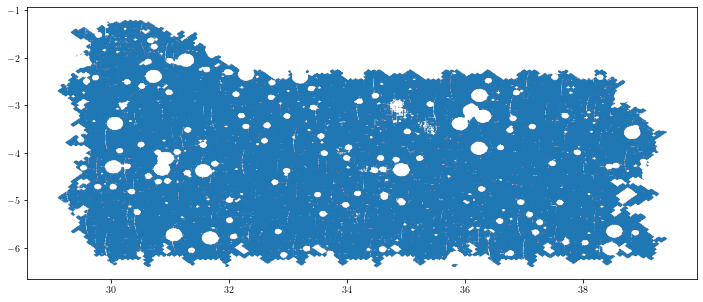

In [7]:
fig=plt.figure(figsize=(12,5))
plt.scatter(data['i_ra'],data['i_dec'],s=0.001)

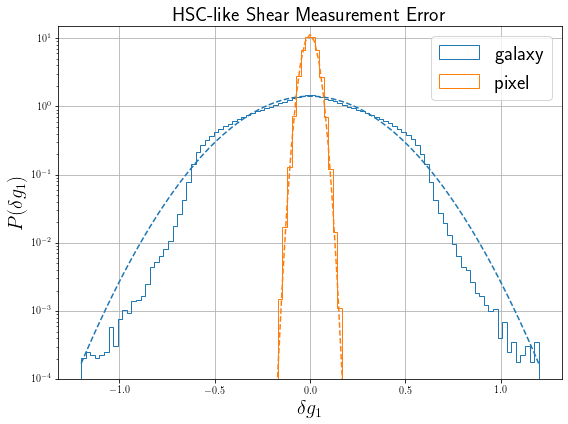

In [79]:
from scipy.stats import norm
cmap=plt.get_cmap('tab20')

g1nAll=[];g2nAll=[];wAll=[]
for itry in range(20):
    np.random.seed(itry)
    g1n,g2n =   rotCatalog(g1,g2)
    g1nAll.extend(g1n)
    g2nAll.extend(g2n)
    wAll.extend(weight)
    del g1n,g2n

g1pixAll=[]
for _i in range(100):
    g1pixAll.append(pyfits.getdata('wrkDir/sim/HSC-obs/20200328/pixes/pixShearR-g1-sim%s.fits' %_i)[:,24:72,24:72].flatten())
g1pixAll=np.hstack(g1pixAll)

plt.figure(figsize=(8,6))

gbin=plt.hist(g1nAll,bins=100,density=True,range=(-1.2,1.2),histtype='step',label='galaxy',color=cmap(0))[1]
gbinGal=(gbin-np.average(g1nAll))/np.std(g1nAll)
a=norm.pdf(gbinGal)
plt.plot(gbin,a/np.sum(a)/(gbin[1]-gbin[0]),color=cmap(0),ls='--')

gbin=plt.hist(g1pixAll,bins=100,density=True,range=(-1.2,1.2),histtype='step',label='pixel',color=cmap(2))[1]
gbinPix=(gbin-np.average(g1pixAll))/np.std(g1pixAll)
a=norm.pdf(gbinPix)
plt.plot(gbin,a/np.sum(a)/(gbin[1]-gbin[0]),color=cmap(2),ls='--')

plt.title('HSC-like Shear Measurement Error',fontsize=20)
plt.xlabel(r'$\delta g_1$',fontsize=20)
plt.ylabel(r'$P(\delta g_1)$',fontsize=20)
plt.legend(fontsize=20)
plt.yscale('log')
plt.ylim(1e-4,15)
plt.grid()
plt.tight_layout()
plt.savefig('../doc/paper_ms_method_HSCY1/shapeMeasurementError-HSCY1.pdf')